In [24]:
from lib.utils import *
from lib.models import *
from lib.ekyn import *
from lib.env import *
from lib.datasets import *

In [25]:
class Gandalf(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = Frodo(n_features=5000,device=DEVICE).to(DEVICE)
        self.lstm = nn.LSTM(16,32,bidirectional=True)
        self.fc1 = nn.Linear(64,3)
    def forward(self,x_2d,classification=True):
        x_2d = x_2d.view(-1,9,1,5000)
        x = torch.Tensor().to(DEVICE)
        for t in range(x_2d.size(1)):
            xi = self.encoder(x_2d[:,t,:,:],classification=False)
            x = torch.cat([x,xi.unsqueeze(0)],dim=0)
        out,_ = self.lstm(x)
        if(classification):
            x = self.fc1(out[-1])
        else:
            x = out[-1]
        return x
class Windowset(Dataset):
    def __init__(self,X,y):
        self.X = cat([zeros(4,5000),X,zeros(4,5000)])
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.X[idx:idx+9].flatten(),self.y[idx])
model = Gandalf()
model.load_state_dict(torch.load(f=f'./best_model.pt',map_location='cpu'))
model.to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()

In [26]:
ids = [filename.split(' ')[1] for filename in os.listdir(f'../data/courtney_aug_oct_2022_baseline_recordings/2_labels/')]
all_metrics = pd.DataFrame()

In [27]:
for filename in ids:
    print(filename)
    if filename == '22-Oct-A':
        continue
    fs = 500
    raw = read_raw_edf((f'../data/courtney_aug_oct_2022_baseline_recordings/1_raw_edf/{filename}.edf'),verbose=False)
    measurement_date = raw.info["meas_date"]
    eeg = raw.get_data(picks='EEG 1')[0]
    df = pd.read_excel(f'../data/courtney_aug_oct_2022_baseline_recordings/2_labels/CW {filename} Baseline.xls')
    df = df.drop(0).reset_index(drop=True)
    df = fix_gaps(df)
    df.loc[df['Label'] == 'X','Label'] = NA
    df = df.fillna(method='ffill')
    print(df['Start Time'].diff().value_counts())
    print(df['Label'].value_counts())
    start_time = df['Start Time'][0]
    end_time = df.iloc[-1,0]
    length = (end_time - start_time)
    times = [start_time + datetime.timedelta(seconds=10*i) for  i in range(int((length.days*86400 + length.seconds)/10)+1)]
    print(len(times))
    print(times[0])
    print(times[-1])
    eeg = raw.get_data(picks='EEG 1')[0]
    print(eeg.shape[0]/500)
    measurement_date = measurement_date.replace(tzinfo=None)
    offset = df.iloc[0,0] - measurement_date
    eeg = eeg[offset.seconds*500:]
    print(eeg.shape[0]/500)
    eeg = eeg[:len(times)*5000]
    print(eeg.shape[0]/500)
    eeg = from_numpy(eeg.reshape(-1, 5000)).float()
    print(eeg.shape)
    y = one_hot(from_numpy(Categorical(df['Label']).codes.copy()).long()).float()
    dataloader = DataLoader(Windowset(eeg,y),batch_size=32,shuffle=False)
    loss,metrics,y_true,y_pred,logits = evaluate(dataloader,model,criterion,DEVICE)
    all_metrics = pd.concat([all_metrics,pd.Series(metrics,name=f'{filename}')],axis=1)

22-Oct-E
WARNING *** file size (1897543) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
0 days 00:00:10    34559
Name: Start Time, dtype: int64
W    18975
S    13905
P     1680
Name: Label, dtype: int64
34560
2022-10-28 04:00:00
2022-11-01 03:59:50
414100.0
367788.0
345600.0
torch.Size([34560, 5000])
22-Aug-D
WARNING *** file size (1895209) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
0 days 00:00:10    34559
Name: Start Time, dtype: int64
W    16078
S    16039
P     2443
Name: Label, dtype: int64
34560
2022-08-19 07:00:00
2022-08-23 06:59:50
409820.0
355098.0
345600.0
torch.Size([34560, 5000])
22-Oct-H
WARNING *** file size (1895641) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
0 days 00:00:10    34559
Name: Start Time, dtype: int64
W    16431
S    15548
P     2581
Name: Label, dtype: i

In [28]:
all_metrics

,22-Oct-E,22-Aug-D,22-Oct-H,22-Aug-B,22-Oct-D,22-Aug-F,22-Aug-H,22-Oct-G,22-Aug-E
precision,0.828169,0.854984,0.921271,0.875949,0.890852,0.795989,0.754995,0.838566,0.710075
recall,0.888147,0.831565,0.911600,0.888186,0.853743,0.854105,0.889679,0.842297,0.811661
f1,0.852065,0.832575,0.914975,0.881333,0.870303,0.813079,0.781896,0.840375,0.718714


In [20]:
filename = '22-Oct-D'
fs = 500
raw = read_raw_edf((f'../data/courtney_aug_oct_2022_baseline_recordings/1_raw_edf/{filename}.edf'),verbose=False)
measurement_date = raw.info["meas_date"]
eeg = raw.get_data(picks='EEG 1')[0]
df = pd.read_excel(f'../data/courtney_aug_oct_2022_baseline_recordings/2_labels/CW {filename} Baseline.xls')
df = df.drop(0).reset_index(drop=True)
df = fix_gaps(df)
df.loc[df['Label'] == 'X','Label'] = NA
df = df.fillna(method='ffill')
print(df['Start Time'].diff().value_counts())
print(df['Label'].value_counts())
start_time = df['Start Time'][0]
end_time = df.iloc[-1,0]
length = (end_time - start_time)
times = [start_time + datetime.timedelta(seconds=10*i) for  i in range(int((length.days*86400 + length.seconds)/10)+1)]
print(len(times))
print(times[0])
print(times[-1])
eeg = raw.get_data(picks='EEG 1')[0]
print(eeg.shape)

WARNING *** file size (1897489) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
0 days 00:00:10    34559
Name: Start Time, dtype: int64
W    17211
S    15051
P     2298
Name: Label, dtype: int64
34560
2022-10-28 04:00:00
2022-11-01 03:59:50
(207050000,)


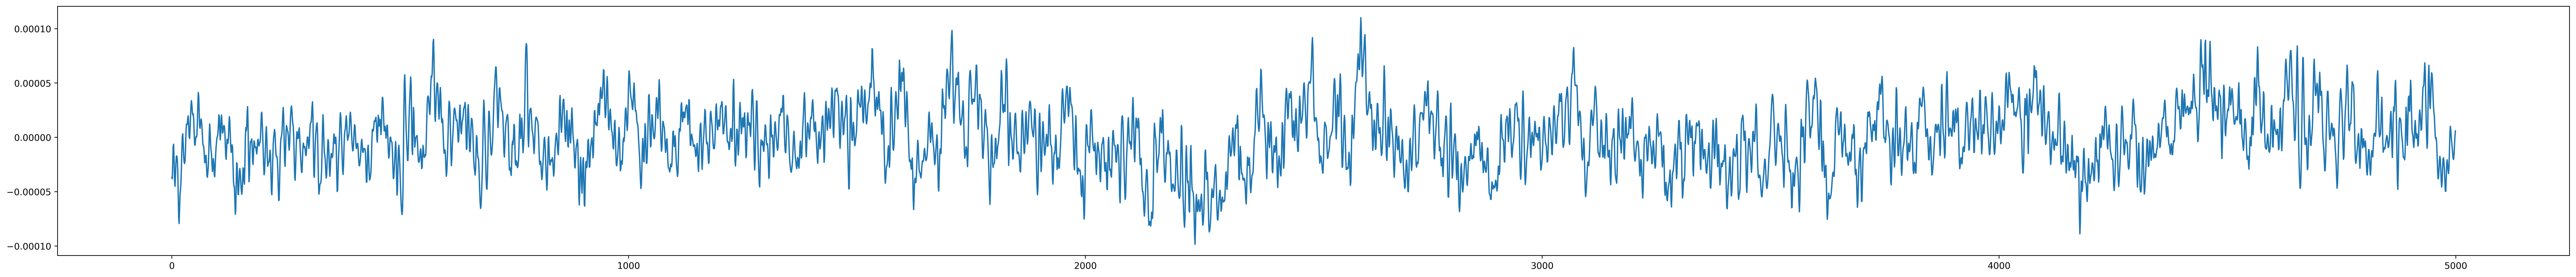

In [17]:
plt.figure(figsize=(50,5),dpi=500)
plt.plot(eeg[0])
plt.savefig('out.pdf')

In [22]:
all_metrics

,22-Oct-H,22-Oct-D,22-Oct-H,22-Oct-D,22-Oct-H,22-Oct-D,22-Oct-G,22-Oct-H,22-Oct-D,22-Oct-G,22-Oct-E,22-Aug-F
precision,0.921271,0.890852,0.921271,0.890852,0.921271,0.890852,0.838566,0.921271,0.890852,0.838566,0.828169,0.795989
recall,0.911600,0.853743,0.911600,0.853743,0.911600,0.853743,0.842297,0.911600,0.853743,0.842297,0.888147,0.854105
f1,0.914975,0.870303,0.914975,0.870303,0.914975,0.870303,0.840375,0.914975,0.870303,0.840375,0.852065,0.813079
